In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

numpy = lambda x : x.detach().cpu().numpy()

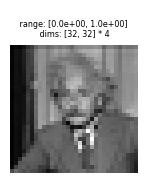

In [2]:
image = plt.imread('../data/einstein.pgm').astype(float)
image = pt.blurDn(image, 3, 'qmf9')
# keeping it small, so that we can rapidly check against the exact computation
image = po.rescale(image, 0, 1)
pt.imshow(image, zoom=4);

# TODO let the Eigendistortion class take care of that when it recieves a numpy array
x = torch.tensor(image).unsqueeze(0).unsqueeze(0)

class toy_model(nn.Module):
    def __init__(self, cmplx=False):
        super(toy_model, self).__init__()

        self.SPF = po.simul.Steerable_Pyramid_Freq(image.shape, order=2, height=2, is_complex=False)
        self.nl = po.simul.local_gain_control

#         self.SPF = po.simul.Steerable_Pyramid_Freq(image.shape, order=2, height=2, is_complex=True)
#         self.nl = po.simul.rectangular_to_polar_dict
    
    def forward(self, x):
        
        pyr = self.SPF(x) 
        _, state = self.nl(pyr)

        return torch.cat([s.squeeze().view(-1) for s in state.values()]).unsqueeze(1)

M = toy_model()

In [3]:
# (M(x))

In [4]:
# first order Taylor approximation (this takes about a minute)
x_flat = x.flatten().unsqueeze(1).requires_grad_()
J = po.synth.autodiff.jacobian(M(x_flat.view_as(x)), x_flat)

(3840, 1024)


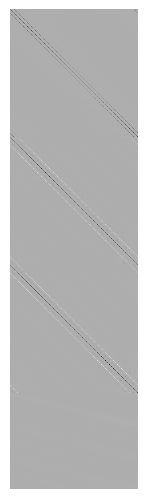

In [5]:
J = numpy(J)
print(J.shape) # out by in

pt.imshow(J, zoom=.125, title=None);

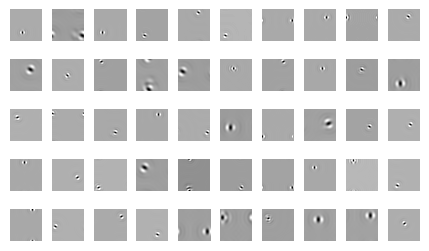

In [6]:
# visualization of some random channels
# as expected
N = 50
random_lines_J = J[np.random.choice(np.arange(len(J)), N, replace=False)]
pt.imshow(random_lines_J.reshape(N, *image.shape),col_wrap=10, title=None);

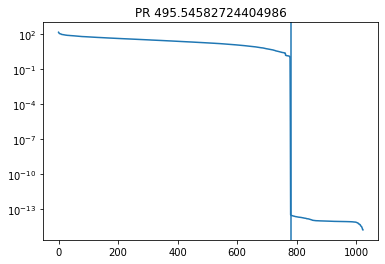

In [7]:
# computing the svd
U,s,Vh = np.linalg.svd(J)
# Note that svd returns the conjugate transpose of V,
# columns of V form a basis of the input space
# so here we need to look as rows of Vh (its real valued).

# finding where nullspace roughly starts
threshold = np.where(np.log(s) < -20)[0].min()
# a way to think about effective dimensionality
participation_ratio = (s.sum() ** 2 / (s ** 2).sum())

plt.plot(s) # is indeed in decreasing order (contrary to np.linalg.eig)
plt.axvline(threshold)
plt.yscale('log')
plt.title('PR '+ str(participation_ratio))
plt.show()

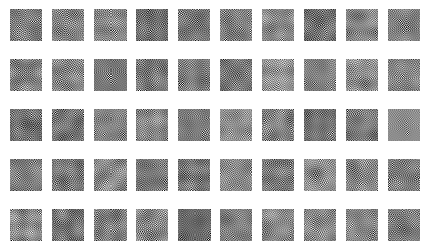

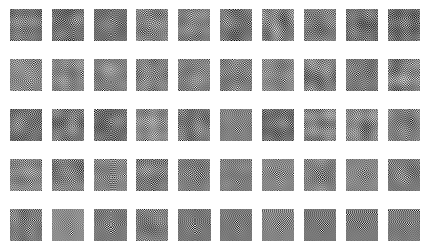

In [8]:
# looking at some of the basis vectors of the nullspace
# indeed our model disgards high frequencies
random_nullspace = Vh[np.random.choice(np.arange(threshold, len(Vh), 1), N, replace=False)]
pt.imshow(random_nullspace.reshape(N, *image.shape),
          title=None, col_wrap=10);
# the bottom evecs
pt.imshow(Vh[-50:].reshape(N, *image.shape),
          title=None, col_wrap=10);

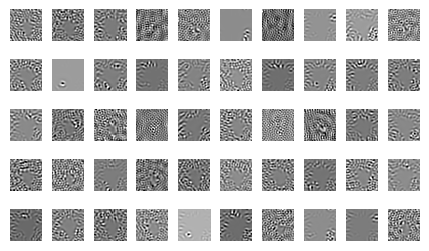

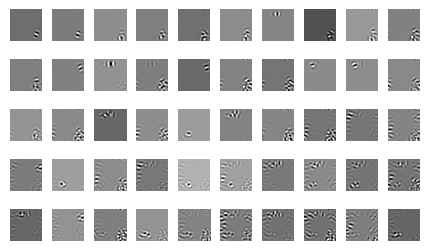

In [9]:
# looking at some basis vectors of the column space (reweighted for fun)
prob = (s[:threshold])
prob /= prob.sum()
random_colspace = Vh[np.random.choice(np.arange(0, threshold, 1), N, replace=False, p=prob)]

pt.imshow(random_colspace.reshape(N, *image.shape),
          title=None, col_wrap=10);

# the actual dominant evecs
pt.imshow(Vh[:N].reshape(N, *image.shape),
          title=None, col_wrap=10);